# Build a brain model for cell1

In [1]:
from brian2tools import *
from brian2 import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load The Data

In [4]:
df_v = pd.read_csv('cell1_v.csv')
df_ic = pd.read_csv('cell1_ic.csv')
df_inoise = pd.read_csv('cell1_i_noise.csv')
df_wn_v = pd.read_csv('cell1_v_noise.csv')

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

In [7]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

In [8]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

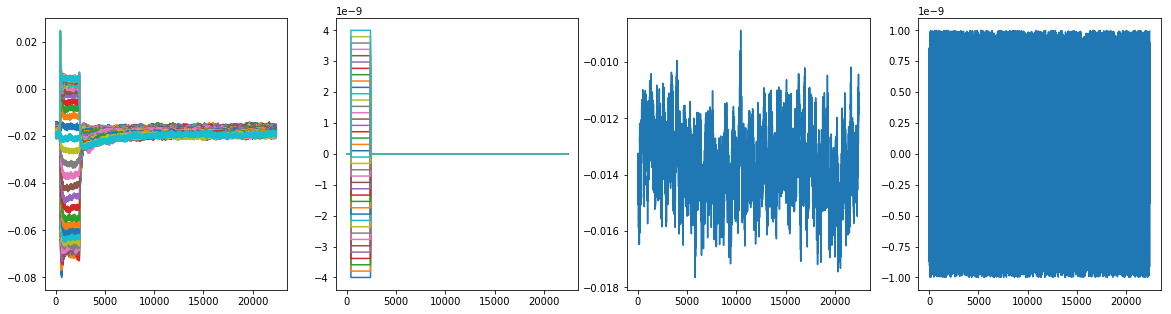

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax[0].plot(Vout.transpose());
ax[1].plot(Ic.transpose());
ax[2].plot(Vnoise);
ax[3].plot(Inoise);

In [10]:
output = np.concatenate((Vout, [Vnoise[:-1]]))
np.shape(output)

(41, 22399)

In [11]:
input_cur = np.concatenate((Ic, [Inoise]))
np.shape(input_cur)

(41, 22400)

## Build a model

In [12]:
from brian2.units.constants import faraday_constant as F
from brian2.units.constants import gas_constant as R
from brian2.units.constants import zero_celsius as temp

In [13]:
model = Equations('''
v1 = (abs(v)+0.0001*mV)*sign(v): volt

dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-v1*F)/(R*T))) +I(t))/C : volt
dn/dt = (1-n)*alpha_n - beta_n*n : 1
dm/dt = (1-m)*alpha_m - beta_m*m : 1
dh/dt = (1-h)*alpha_h - (beta_h*u*h)/amp : 1
du/dt = (g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-v1*F)/(R*T))) - u)/tau_ca : amp

vn = (abs(v-Vn)+0.0001*mV)*sign(v-Vn): volt
alpha_n = (1/(2 * kn * taun)) * vn/(1-exp(-vn/kn)) : Hz 
beta_n = -(1/(2 * kn * taun)) * vn/(1-exp(vn/kn)) : Hz 

vm = (abs(v-Vm)+0.0001*mV)*sign(v-Vm): volt
alpha_m = (1/(2 * km * taum)) * vm/(1-exp(-vm/km)) : Hz 
beta_m = -(1/(2 * km * taum)) * vm/(1-exp(vm/km)) : Hz 

C: farad (constant)
EL: volt (constant)
gL: siemens (constant)

g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)

g_Ca : siemens (constant)
km : volt (constant)
taum : second (constant)
Vm: volt (constant)
E_ca: volt (constant)

alpha_h: Hz (constant)
beta_h: Hz (constant)
tau_ca: second(constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              )

In [14]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [15]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states(
{
'C': 1,
'EL': 1,
'gL': 1,
'g_k': 1,
'kn': 1,
'taun': 1,
'Vn': 1,
'Ek': 1,
'g_Ca': 1,
'km': 1,
'taum': 1,
'Vm': 1,
'E_ca': 1,
'alpha_h': 1,
'beta_h': 1,
'tau_ca': 1,}, units=False)

In [16]:
# run(10*ms)

### Model Fitting

In [17]:
model = Equations('''
v1 = (abs(v)+0.0001*mV)*sign(v): volt

dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-v1*F)/(R*T))) +I)/C : volt
dn/dt = (1-n)*alpha_n - beta_n*n : 1
dm/dt = (1-m)*alpha_m - beta_m*m : 1
dh/dt = (1-h)*alpha_h - (beta_h*u*h)/amp : 1
du/dt = (g_Ca*m*h* v*((1-exp(((E_ca-v)*F)/(R*T))))/(1-exp((-v1*F)/(R*T))) - u)/tau_ca : amp

vn = (abs(v-Vn)+0.0001*mV)*sign(v-Vn): volt
alpha_n = (1/(2 * kn * taun)) * vn/(1-exp(-vn/kn)) : Hz 
beta_n = -(1/(2 * kn * taun)) * vn/(1-exp(vn/kn)) : Hz 

vm = (abs(v-Vm)+0.0001*mV)*sign(v-Vm): volt
alpha_m = (1/(2 * km * taum)) * vm/(1-exp(-vm/km)) : Hz 
beta_m = -(1/(2 * km * taum)) * vm/(1-exp(vm/km)) : Hz 

C: farad (constant)
EL: volt (constant)
gL: siemens (constant)

g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)

g_Ca : siemens (constant)
km : volt (constant)
taum : second (constant)
Vm: volt (constant)
E_ca: volt (constant)

alpha_h: Hz (constant)
beta_h: Hz (constant)
tau_ca: second(constant)
''',
T = temp+20*kelvin,
F = F, 
R = R,              )

In [18]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [19]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
metric = MSEMetric()

In [20]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur[:, :-1] * amp, output=output * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        # Leak
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],  

                        # K
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],

                        g_k=[1e-1*uS, 1e3*uS],
                        taun=[1*ms, 100*ms],

                        # Ca
                        km=[4*mV, 15*mV],
                        taum=[0*ms, 4*ms],
                        Vm=[0*mV, 40*mV],
                        E_ca=[0*mV, 100*mV],

                        g_Ca=[1e-1*uS, 1e6*uS],
                        alpha_h=[1*Hz, 100*Hz],
                        beta_h=[1*Hz, 10000*Hz],
                        tau_ca=[1*ms, 200*ms],

                        param_init={'v': -30 * mV},
                        n_rounds=20, n_samples=30, optimizer=n_opt, metric=metric)

WARNING    neurons's variable 'u' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'h' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'n' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurons's variable 'm' has NaN, very large values, or encountered

index 0 errors minimum: 82.37998574949037
index 1 errors minimum: 71.21898110108508
index 2 errors minimum: 46.613373247070726
index 3 errors minimum: 24.15177264244113
index 4 errors minimum: 21.464882016349005
index 5 errors minimum: 17.130963886347967
index 6 errors minimum: 11.837691008223901
index 7 errors minimum: 7.949483101957788
index 8 errors minimum: 7.115167076389694
index 9 errors minimum: 7.024290715290076
index 10 errors minimum: 6.144884360978919
index 11 errors minimum: 5.465200857140677
index 12 errors minimum: 5.3256364677572625
index 13 errors minimum: 5.146642944228042
index 14 errors minimum: 5.006438481380771


WARNING    /home/alteska/Desktop/brian/brian2tools/brian2tools/modelfitting/metric.py:152: RuntimeWarning: overflow encountered in square
  mse = sum(square(temp_out - trace))
 [py.warnings]


index 15 errors minimum: 4.968466450440297
index 16 errors minimum: 4.996460968885151
index 17 errors minimum: 4.8495437668616415
index 18 errors minimum: 4.842275047841173
index 19 errors minimum: 4.828327128238315


In [21]:
res

{'gL': 1.9695220383419697e-08,
 'E_ca': 0.0035900377962634136,
 'beta_h': 9652.88782522871,
 'tau_ca': 0.18253536528938147,
 'taum': 0.0038807328161172125,
 'kn': 0.007562989814065672,
 'Vn': 0.016836261417334575,
 'km': 0.004103416492769887,
 'g_Ca': 0.01018415423994179,
 'EL': -0.010745054597394593,
 'taun': 0.09644630936724452,
 'Vm': 0.03547394529943897,
 'C': 3.8279058071314175e-10,
 'alpha_h': 93.46116622731711,
 'Ek': -0.001514232928231725,
 'g_k': 1.0834624824762281e-05}

In [22]:
# print('EL', res['EL'] * volt)
# print('C', res['C'] * farad)
# print('gL', res['gL'] * siemens)

# print('kn', res['kn'] * volt)
# print('Vn', res['Vn'] * volt)
# print('Ek', res['Ek'] * volt)

print('g_k', res['g_k'] * siemens)
print('taun', res['taun'] * second)

# print('km', res['km'] * volt)
# print('taum', res['taum'] * volt)
# print('Vm', res['Vm'] * volt)
# print('E_ca', res['E_ca'] * volt)

print('g_Ca', res['g_Ca'] * volt)
print('alpha_h', res['alpha_h'] * Hz)
print('beta_h', res['beta_h'] * Hz)
print('tau_ca', res['tau_ca'] * second)

g_k 10.83462482 uS
taun 96.44630937 ms
g_Ca 10.18415424 mV
alpha_h 93.46116623 Hz
beta_h 9.65288783 kHz
tau_ca 182.53536529 ms


In [23]:
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     param_init={'v': -30 * mV},
                     dt=dt)

fits/mV

array([[-30.        , -29.95052869, -29.90118709, ..., -22.18127979,
        -22.18127979, -22.18127979],
       [-30.        , -29.95052869, -29.90118709, ..., -22.18127979,
        -22.18127979, -22.18127979],
       [-30.        , -29.95052869, -29.90118709, ..., -22.18127979,
        -22.18127979, -22.18127979],
       ...,
       [-30.        , -29.95052869, -29.90118709, ..., -22.18127979,
        -22.18127979, -22.18127979],
       [-30.        , -29.95052869, -29.90118709, ..., -22.18127979,
        -22.18127979, -22.18127979],
       [-30.        , -30.02175156, -29.93776897, ..., -20.67484081,
        -20.73892268, -20.68307305]])

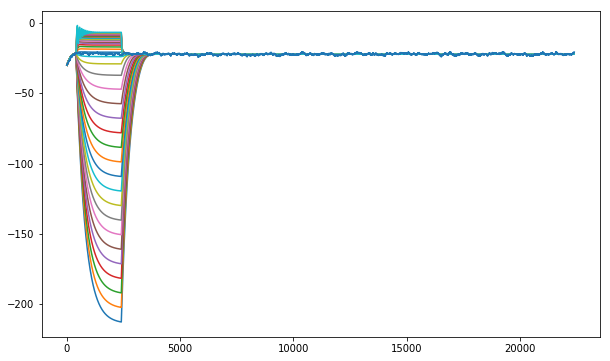

In [24]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());

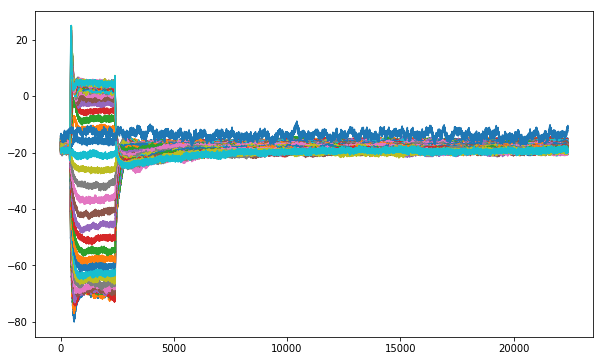

In [25]:
plt.figure(figsize=(10,6))
plot((output/1e-3).transpose());

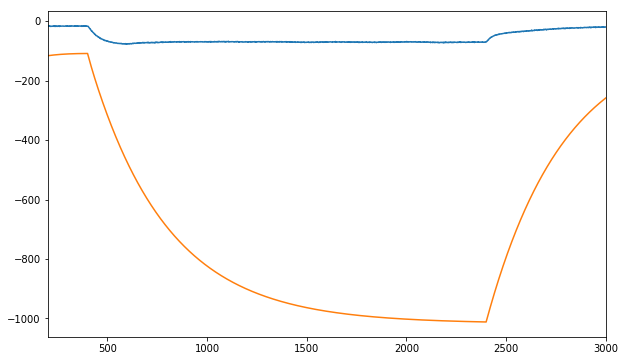

In [26]:
d=1
plt.figure(figsize=(10,6))
plt.xlim(200,3000)
# plt.ylim(-22,-19)
plot((output[d]/1e-3).transpose());
plot((fits[d]*5/mV).transpose());